In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import math
import sys
#sys.path.insert(0,'/usr/local/lib/python3.5/dist-packages/')
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D
import copy as copy
from scipy.spatial import ConvexHull
import matplotlib.tri as mtri
import pickle
from scipy.integrate import odeint

In [2]:
def saveThing(thing,file):
    with open(file,'wb') as fil:
        pick = pickle.Pickler(fil,protocol=4)
        pick.dump(thing)
        pick.clear_memo()
def openThing(file):
    with open(file,'rb') as fil:
        pick = pickle.Unpickler(fil)
        thing = pick.load()
    return thing

In [3]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

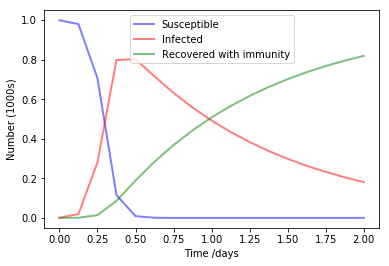

In [4]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 25, 1
# A grid of time points (in days)
t = np.linspace(0, 2, 17)

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.legend()
plt.show()

In [5]:
# The SIR model differential equations.
def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

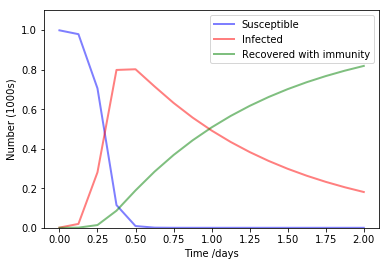

In [35]:
# Total population, N.
N = 1
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 0.001, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = 1 - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 25, 1
# A grid of time points (in days)
t = np.linspace(0, 2, 17)

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim([0,1.1])
ax.legend()
plt.show()

In [36]:
S_sym, I_sym, R_sym, t_sym = sy.symbols("S_sym I_sym R_sym t_sym")
dS_sym, dI_sym, dR_sym = sy.symbols("dS_sym dI_sym dR_sym")
beta_sym, gamma_sym = sy.symbols("beta_sym gamma_sym")

dS_sym = -beta_sym*S_sym(t_sym)*I_sym(t_sym)
dI_sym = beta_sym*S_sym(t_sym)*I_sym(t_sym) - gamma_sym*I_sym(t_sym)
dR_sym = gamma_sym*I_sym(t_sym)

derivSubs = [(sy.Derivative(S_sym(t_sym), t_sym),dS_sym),(sy.Derivative(I_sym(t_sym), t_sym),dI_sym)]

derivs = [I_sym(t_sym),dI_sym]
for i in range(2):
    derivs.append(derivs[-1].diff(t_sym).subs(derivSubs))

In [37]:
def evalDeriv(S,I,der):
    return [der.subs([(I_sym(t_sym),I[i]),(S_sym(t_sym),S[i]),(beta_sym,beta),(gamma_sym,gamma)]) for i in range(len(S))]

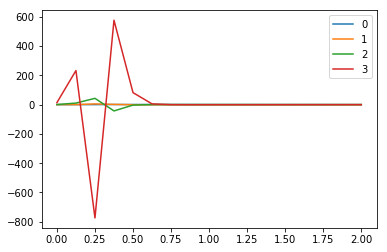

In [39]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
idx = 0
for der in derivs:
    ax.plot(t, evalDeriv(S,I,der), label=str(idx))
    idx += 1
#ax.set_ylim([0,1.1])
ax.legend()
plt.show()